# *TASK3: PRETENS - SUBTASK1*


This notebook is a starting code for the Task3-Subtask1 for the PreTens in SemEval. In this notebook, you will find an end2end pipelne showing how the data is used for a baseline evaluation. 
The script includes a simple classification model using n-grams as features. The data for subtask-1 is divided into three-folds. For convinience, we provided the folds in the SemEval task git repository.

The participants can use the given fold to re-create the below experiment. The participant are free to merge the whole data (i.e, folds) and do customised split.

This task include 3 languages: English (En), French (Fr) and Italian (It)



In [1]:
# -*- coding: utf-8 -*- #
"""*********************************************************************************************"""
#   FileName     [ SemEval-Task3-Baseline-subtask1.ipynb ]
#   Synopsis     [ Scripts for re-creating baselines using N-grams features
#                  with linear classifier and validated using cross-validation   ]
#   Author       [ Shammur A Chowdhury ]

"""*********************************************************************************************"""


'*********************************************************************************************'

Cloning the git repository, to get data for Task3:subtask-1


In [ ]:
##### Data Reader -- English/French/Italian
!git clone https://github.com/shammur/SemEval2022Task3.git
%cd ./SemEval2022Task3/
#data/train/train_subtask-2/
!ls

Cloning into 'SemEval2022Task3'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 235 (delta 100), reused 87 (delta 29), pack-reused 0
Receiving objects: 100% (235/235), 627.89 KiB | 11.63 MiB/s, done.
Resolving deltas: 100% (100/100), done.
/content/SemEval2022Task3
baseline  data	LICENSE  pretens_logo.png  README.md  Task-timeline


Setting up the environment for the task

In [ ]:
import os, sys, time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from scipy import stats
from collections import defaultdict
import numpy as np
import pandas as pd
import statistics

from baseline.utils import get_train_dev, compute_metrics_task1, process_eval_jsons_task1

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)



Task Path setups


In [ ]:
##Task Paths and Setups
task_folder="./data/train/train_subtask-1/"
languages=['En', 'Fr', 'It']
fold_sets=['fold_0', 'fold_1', 'fold_2']

Function used to run the training and evaluation loop.
Below we are selecting one fold as test and the rest is merged (in case of more than 2 folds) to make training data
 

In [ ]:
def run_train_and_evaluation_folds(fold_tables, ngram=3):
  selected_folds=0
  jsons=[]

  
  while selected_folds <len(fold_tables):
    print(selected_folds, 'selected_folds')
    ###Creating train test ...
    train, dev=get_train_dev(selected_folds,fold_tables)
    
    
    # #converting to lower case
    # train['Sentence'] = train.Sentence.map(lambda x: x.lower()) 
    # dev['Sentence'] = dev.Sentence.map(lambda x: x.lower()) 

    # #Removing the punctuation
    # train['Sentence'] = train.Sentence.str.replace('[^\w\s]', '')  
    # dev['Sentence'] = dev.Sentence.str.replace('[^\w\s]', '')  

    # #splitting the word into tokens
    # train['Sentence'] = train['Sentence'].apply(tokenize.word_tokenize) 
    # dev['Sentence'] = dev['Sentence'].apply(tokenize.word_tokenize) 

    # #stemming
    # stemmer = PorterStemmer()
    # df['Sentence'] = df['Sentence'].apply(lambda x: [stemmer.stem(y) for y in x]) 

    #Get text and lables
    train_texts=(train['Sentence'])
    y_train=np.array(train['Labels'])

    
    dev_texts=(dev['Sentence'])
    test_true_y=np.array(dev['Labels'])   

    tfidf_vectorizer = TfidfVectorizer(encoding='utf-8', lowercase=True, ngram_range=(1, ngram), norm='l1',
                                           use_idf=True, max_df=0.95, min_df=3, max_features=1000) 

    train_x_feat = tfidf_vectorizer.fit_transform(train_texts)
    
    
    classifier = LinearSVC(random_state=RANDOM_SEED, C=1.0, class_weight='balanced', tol=0.0001).fit(train_x_feat,
                                                                                                     y_train)
    ##Testing:
    test_x_feat = tfidf_vectorizer.transform(dev_texts)
    test_pred_y = classifier.predict(test_x_feat)
    
    jsons.append(compute_metrics_task1(test_pred_y,test_true_y))
    selected_folds+=1
    
  return jsons

The main task loop for all the involed languages



In [ ]:
###Running the SubTask-1 for mentioned languages:

for lang in languages:
  taskid=lang+'-Subtask1-'
  file_path=task_folder+lang.lower()
  print('Running for Task1 in Folder:', file_path)
  
  fold_tables = [pd.read_csv(os.path.join(file_path, taskid+s + '.tsv'), sep="\t") for s in fold_sets]
  print("Data Sample for Language: ", lang)
  print(fold_tables[0].head()) 

  en_eval_jsons=[]
  en_eval_jsons.extend(run_train_and_evaluation_folds(fold_tables, ngram=3))
  header_row = ['fold 0', 'fold 1', 'fold 2', 'average']
  df= process_eval_jsons_task1(en_eval_jsons)
  df.insert(loc=0, column='#', value=header_row)
  print('Printing Results for Language: ', lang)
  print(df.to_markdown()+"\n") 


Running for Task1 in Folder: ./data/train/train_subtask-1/en
Data Sample for Language:  En
     ID                               Sentence  Labels
0  5155            I like ham , but not fish .       1
1  2560  I like restaurants , and clerks too .       1
2  3711      I like jewelry more than skirts .       1
3  2232        I like seafood , and veal too .       1
4  2376      I like pets , and jellyfish too .       1
0 selected_folds
1 selected_folds
2 selected_folds
Printing Results for Language:  En
|    | #       | accuracy           | Precision          | Recall             | F1                 | F1macro            |
|---:|:--------|:-------------------|:-------------------|:-------------------|:-------------------|:-------------------|
|  0 | fold 0  | 0.8745501285347044 | 0.8525345622119815 | 0.9167492566897919 | 0.883476599808978  | 0.8738095693922395 |
|  1 | fold 1  | 0.8591259640102827 | 0.8266666666666667 | 0.9217046580773043 | 0.8716026241799437 | 0.8577830888553477 |
|  2 

**CV Results:**

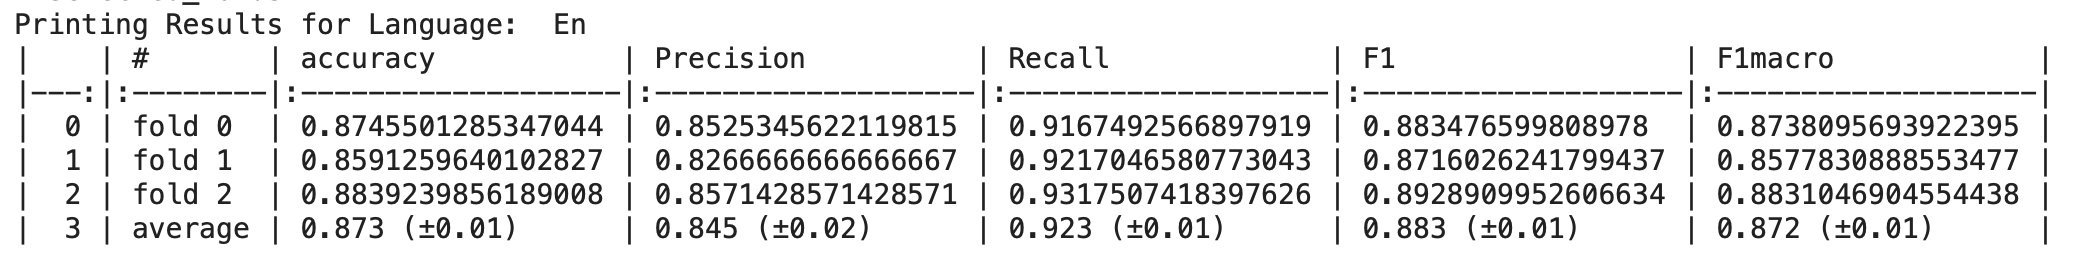

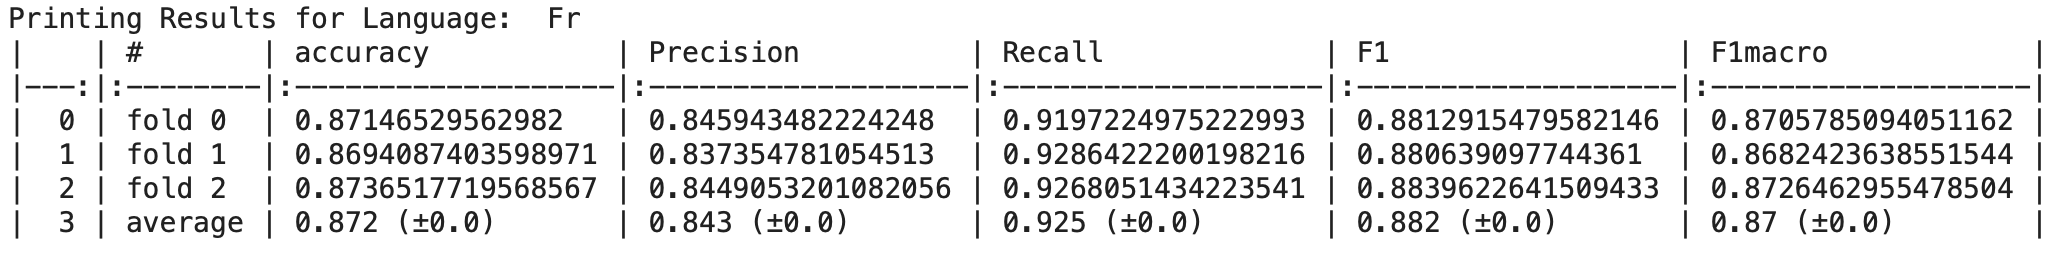

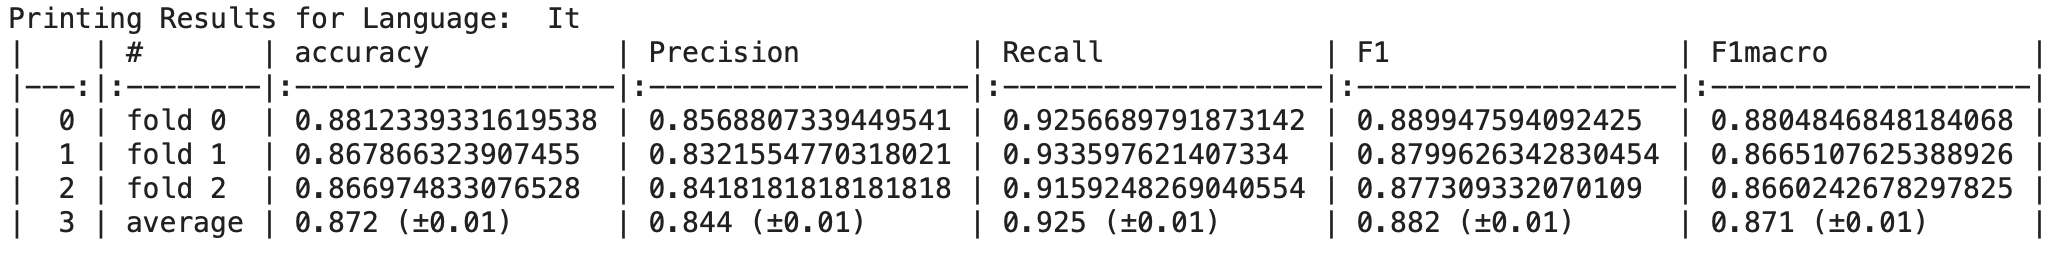